In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys, os, time, math
sys.path.append('/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj')
import jcTrajectory_CP as cellTraj
import h5py
import pickle
import subprocess
import umap
import scipy
from csaps import csaps
import string
from joblib import dump, load
from datetime import date

In [2]:
######### Parameters of transitions between "macroscopic" states ##########
nstates_final = 7
max_states = 100
pcut_final = 0.094
n_components_tMat = 15
trajl = 40 # Trajectory Length for morphodynamical trajectory analysis

wellsInfo = 'Awells'
conditions = ['A2'] # LIGANDS or CONDITIONS
tmSet = ['EGF1']

In [3]:
nConditions = len(tmSet) # Total number of Ligand Conditions
#os.environ['OMP_NUM_THREADS'] = '1'; os.environ['MKL_NUM_THREADS'] = '1'

today = date.today()
date2day = today.strftime("%b%d-%Y")
sysName = 'LI204601_P'
figid = sysName+'_tlen'+str(trajl)+'_'+date2day

# Indices for the ligands 
inds_tmSet = [i for i in range(nConditions)]
inds_tmSet = np.array(inds_tmSet).astype(int)
nfovs = 1
fovs = [i for i in range(1, nfovs + 1)]
fovs = np.array(fovs).astype(int)
dateSet = ['']
pathSet = ['/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/']
imagingSet = [0 for i in range(nConditions)]
modelList = [None]*(nfovs*(nConditions))
modelList_conditions = np.zeros(nfovs*(nConditions)).astype(int)

In [4]:
i = 0
icond = 0
for cond in conditions:
    for fov in fovs:
        modelList_conditions[i] = icond
        modelList[i] = pathSet[imagingSet[icond]]+sysName+'_'+cond+'_'+str(fov)+dateSet[imagingSet[icond]]
        #print("Models: ",modelList[i])
        i = i + 1
    icond = icond + 1

nmodels = len(modelList)
modelSet = [None]*nmodels
indgood_models = np.array([]).astype(int)

In [5]:
for i in range(nmodels):
    try:
        objFile = modelList[i]+'.obj'
        objFileHandler = open(objFile,'rb')
        modelSet[i] = pickle.load(objFileHandler)
        print('loaded '+objFile+' with '+str(modelSet[i].cells_indSet.size)+' cells')
        objFileHandler.close()
        test = len(modelSet[i].linSet)
        indgood_models = np.append(indgood_models,i)
    except:
        print("ERROR in reading *.obj files")
        sys.exit(0)

loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_1.obj with 51054 cells


In [6]:
# Total number of frames (image snapshots) in one condition per FOVs
nframes = 193 
cellnumber_stdSet = np.ones(nmodels)*np.inf
# range of frame indices where cell numbers are higher: ~70-98%
sframe = 70.*nframes/100.; sframe = math.ceil(sframe)
eframe = 98.5*nframes/100.; eframe = math.ceil(eframe)
cellnumber_frames = np.arange(sframe, eframe).astype(int)
cellnumber_std_cut = .50 # This was set to 0.10 by Jeremy 
frames = np.arange(nframes)
# Abscissas at which smoothing will be done using CSAPS package
abSmooth = np.linspace(frames[0], frames[-1], 10000)

In [7]:
for i in indgood_models:
    ncells = np.zeros(nframes)
    ncells_smooth = np.zeros_like(ncells)
    for iS in range(nframes):
        ncells[iS] = np.sum(modelSet[i].cells_frameSet == iS)
    # Cubic Spline Approximation (CSAPS) to smoothen the data
    splfov = csaps(frames, ncells/ncells[0], abSmooth, smooth = 0.98) # Scaled by ncells[0] to avoid large numbers
    ncells_smooth = splfov*ncells[0] # smoothened cell numbers reverse scaled back to original
    cellnumber_std = np.std(ncells[cellnumber_frames] - ncells_smooth[cellnumber_frames])/np.mean(ncells[cellnumber_frames])
    cellnumber_stdSet[i] = cellnumber_std # Standard Deviation in Cell Numbers		

In [8]:
indhigh_std = np.where(cellnumber_stdSet > cellnumber_std_cut)[0]
indgood_models = np.setdiff1d(indgood_models, indhigh_std)
#indgood_models = np.setdiff1d(indgood_models, np.array([51]).astype(int)) #missing comdx for EGF0_4

# get cell counts
n_conds = len(tmSet)
inds_tmSet_models = np.zeros(nmodels).astype(int)
inds_imagingSet_models = np.zeros(nmodels).astype(int)
i = 0
icond = 0
for cond in conditions:
    for fov in fovs:
        inds_tmSet_models[i] = inds_tmSet[icond]
        inds_imagingSet_models[i] = imagingSet[icond]
        i = i + 1
    icond = icond + 1

In [9]:
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        modelSet[i].Xf[np.isnan(modelSet[i].Xf)] = 0.0 #just replace with zeros for now? Not sure best...

In [10]:
nfeat_com = 3
Xf_com0 = np.zeros((0, nfeat_com))
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        Xf_com0 = np.append(Xf_com0,modelSet[i].Xf_com, axis = 0)

av_dx = np.nanmean(Xf_com0[:, 0])
std_dx = np.nanstd(Xf_com0[:, 0])
for i in indgood_models:
    modelSet[i].Xf_com[:, 0] = (modelSet[i].Xf_com[:, 0] - av_dx)/std_dx

In [11]:
wctm = cellTraj.Trajectory() # import Trajectory object 
nfeat = modelSet[indgood_models[0]].Xf.shape[1]
Xf = np.zeros((0, nfeat))
indtreatment = np.array([])
indcellSet = np.array([])
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        Xf = np.append(Xf, modelSet[i].Xf, axis = 0)
        # Indices for each model for later access using them
        indtreatment = np.append(indtreatment, i*np.ones(modelSet[i].Xf.shape[0])) 
        indcellSet = np.append(indcellSet, modelSet[i].cells_indSet)

indtreatment = indtreatment.astype(int)
indcellSet = indcellSet.astype(int)

In [12]:
varCutOff = 10
from sklearn.decomposition import PCA #we will use the sklearn package (intended for ease of use over performance/scalability)
pca = PCA(n_components = varCutOff) #n_components specifies the number of principal components to extract from the covariance matrix
pca.fit(Xf) #builds the covariance matrix and "fits" the principal components
Xpca = pca.transform(Xf) #transforms the data into the pca representation
nPCs = Xpca.shape[1]

wctm.Xpca = Xpca
wctm.pca = pca
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        indsf = np.where(indtreatment == i)[0]
        modelSet[i].Xpca = Xpca[indsf, :]

indgood_models = indgood_models[np.where(inds_imagingSet_models[indgood_models] == 0)[0]]

In [13]:
self = wctm
wctm.trajl = trajl
all_trajSet = [None]*nmodels
for i in indgood_models:
    modelSet[i].get_unique_trajectories()
    all_trajSet[i] = modelSet[i].trajectories.copy()

tracked cell 50891, 25 tracks, 46600 left
tracked cell 50763, 23 tracks, 42400 left
tracked cell 50735, 51 tracks, 41500 left
tracked cell 50076, 1 tracks, 37700 left
tracked cell 49741, 1 tracks, 37600 left
tracked cell 49307, 1 tracks, 37500 left
tracked cell 49056, 18 tracks, 37400 left
tracked cell 48763, 1 tracks, 37100 left
tracked cell 48214, 1 tracks, 36900 left
tracked cell 48008, 1 tracks, 36800 left
tracked cell 47562, 1 tracks, 36500 left
tracked cell 46286, 1 tracks, 35900 left
tracked cell 46119, 3 tracks, 35700 left
tracked cell 45624, 1 tracks, 35600 left
tracked cell 42924, 7 tracks, 34200 left
tracked cell 41889, 2 tracks, 33800 left
tracked cell 41728, 1 tracks, 33700 left
tracked cell 40948, 1 tracks, 33300 left
tracked cell 39770, 1 tracks, 32900 left
tracked cell 39018, 1 tracks, 32500 left
tracked cell 38257, 1 tracks, 32300 left
tracked cell 38063, 6 tracks, 32200 left
tracked cell 37504, 1 tracks, 32000 left
tracked cell 35855, 2 tracks, 31300 left
tracked cell

In [14]:
# Single-cell trajectories over the dimensionally reduced cell features
Xpcat = np.zeros((0, pca.n_components_*trajl + nfeat_com*trajl))
indtreatment_traj = np.array([])
indstack_traj = np.array([])
indframes_traj = np.array([])
cellinds0_traj = np.array([])
cellinds1_traj = np.array([])
cb_ratio_traj = np.array([])
for i in indgood_models:
    print('building trajectory data for model {}...'.format(i))
    modelSet[i].trajectories = all_trajSet[i].copy()
    modelSet[i].trajl = trajl # Trajectory snippet length 
    # Get trajectory snippets of a given length in a sliding window
    modelSet[i].traj = modelSet[i].get_traj_segments(trajl)
    data = modelSet[i].Xpca[modelSet[i].traj, :] # Xpca (feature info) along the single-cell trajectory snippets
    datacom = modelSet[i].Xf_com[modelSet[i].traj, :]
    data = data.reshape(modelSet[i].traj.shape[0], modelSet[i].Xpca.shape[1]*trajl)
    datacom = datacom.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_com.shape[1]*trajl)
    data = np.append(data, datacom, axis = 1)
    indgood = np.where(np.sum(np.isnan(data), axis = 1) == 0)[0] # Consider models as "Good" that don't have NaN in "data" 
    data = data[indgood, :]
    modelSet[i].traj = modelSet[i].traj[indgood, :]
    # Store trajectory snippets of a given length (picked in a sliding window) 
    Xpcat = np.append(Xpcat, data, axis = 0) 
    indtreatment_traj = np.append(indtreatment_traj, i*np.ones(data.shape[0])) # Indices of Treatments (Models) Along a Trajectory
    indstacks = modelSet[i].cells_imgfileSet[modelSet[i].traj[:, 0]]
    indstack_traj = np.append(indstack_traj, indstacks)
    indframes = modelSet[i].cells_frameSet[modelSet[i].traj[:, 0]]
    indframes_traj = np.append(indframes_traj, indframes) # Frame Indices Along a Trajectory
    cellinds0 = modelSet[i].traj[:, 0]
    cellinds0_traj = np.append(cellinds0_traj, cellinds0)
    cellinds1 = modelSet[i].traj[:, -1]
    cellinds1_traj = np.append(cellinds1_traj, cellinds1)
    cb_ratio_traj = np.append(cb_ratio_traj, modelSet[i].Xf[cellinds1, 77])

cellinds0_traj = cellinds0_traj.astype(int)
cellinds1_traj = cellinds1_traj.astype(int)

building trajectory data for model 0...


In [32]:
print(Xpca.shape)
#print(indframes_traj[:50])
#print(cellinds0_traj[-100:])

(51054, 10)


In [16]:
neigen = Xpcat.shape[1] # If embedded trajectories aren't UMAP'ed 
inds_conditions = [None]*n_conds
for imf in range(n_conds):
    indmodels = np.intersect1d(indgood_models, np.where(inds_tmSet_models == imf)[0])
    indstm = np.array([])
    for imodel in indmodels:
        indtm = np.where(indtreatment_traj == imodel)
        indstm = np.append(indstm, indtm)
    inds_conditions[imf] = indstm.astype(int).copy() # Condition (Model) specific trajectory indices 

In [17]:
##### Cluster single-cell trajectories of a given snippet length by using KMeans from deeptime 
from deeptime.clustering import KMeans
n_clusters = 200
model = KMeans(n_clusters = n_clusters,  # Place 200 cluster centers
               init_strategy = 'kmeans++',  # kmeans++ initialization strategy
               max_iter = 0,  # don't actually perform the optimization, just place centers
               fixed_seed = 13)
################################ Initial clustering ###############################
clustering = model.fit(Xpcat).fetch_model() # If embedded trajectories aren't UMAP'ed 

model.initial_centers = clustering.cluster_centers
model.max_iter = 5000
clusters = model.fit(Xpcat).fetch_model() # If embedded trajectories aren't UMAP'ed 
wctm.clusterst = clusters

In [18]:
knn = 50
for i in indgood_models:
    modelSet[i].trajectories = all_trajSet[i].copy()

In [19]:
def get_trajectory_steps(self, inds=None, traj=None, Xtraj=None,
                         get_trajectories=True, nlag=1): # traj and Xtraj should be indexed same
    if inds is None:
        inds = np.arange(self.cells_indSet.size).astype(int)
    if get_trajectories:
        self.get_unique_trajectories(cell_inds=inds)
    if traj is None:
        traj = self.traj
    if Xtraj is None:
        x = self.Xtraj
    else:
        x = Xtraj
    trajp1 = self.get_traj_segments(self.trajl + nlag) # Get trajectory snippets @ snippet_length + nlag
    # Reversed index array inds_nlag is created to keep indices every nlag steps
    inds_nlag = np.flipud(np.arange(self.trajl + nlag - 1, -1, -nlag)).astype(int) # keep indices every nlag
    trajp1 = trajp1[:, inds_nlag]
    ntraj = trajp1.shape[0]
    
    neigen = Xpcat.shape[1]
    x0 = np.zeros((0, neigen))
    x1 = np.zeros((0, neigen))
    inds_trajp1 = np.zeros((0, 2)).astype(int)
    # Matching segments of trajectories and then appending the corresponding feature data from Xpcat to two arrays, 'x0' and 'x1'
    for itraj in range(ntraj):
        test0 = trajp1[itraj, 0:-1] # [0:self.trajl]
        test1 = trajp1[itraj, 1:] # [1:self.trajl+1]
        # traj[:, None] == test0[np.newaxis, :]: This expression compares each segment in 'traj' with 'test0'.
        # The use of [:, None] and [np.newaxis, :] reshapes the arrays for broadcasting, allowing element-wise
        # comparison between each segment in 'traj' and the segment 'test0'. 
        # .all(-1): This checks if all elements in a segment are equal, resulting in a boolean array where each
        # element represents whether a segment in 'traj' matches 'test0'.
        # .any(-1): This determines if there is any match in 'traj' for 'test0'. 'res0' is a boolean array indicating
        # which trajectories in 'traj' match 'test0'
        res0 = (traj[:, None] == test0[np.newaxis, :]).all(-1).any(-1)
        res1 = (traj[:, None] == test1[np.newaxis, :]).all(-1).any(-1)
        if np.sum(res0) == 1 and np.sum(res1) == 1: # If at least one matching array in 'traj' for both 'test0' & 'test1' 
            indt0 = np.where(res0)[0][0] # Collect indices where above matching happens
            indt1 = np.where(res1)[0][0] # Collect indices where above matching happens
            x0 = np.append(x0, np.array([Xpcat[indt0, :]]), axis = 0)
            x1 = np.append(x1, np.array([Xpcat[indt1, :]]), axis = 0)
            inds_trajp1 = np.append(inds_trajp1, np.array([[indt0, indt1]]), axis = 0)
        if itraj%100 == 0:
            sys.stdout.write('matching up trajectory '+str(itraj)+'\n')
    self.Xtraj0 = x0
    self.Xtraj1 = x1
    self.inds_trajp1 = inds_trajp1

In [20]:
dxs = np.zeros((nmodels, n_clusters, neigen))
x0set = np.zeros((0, neigen))
x1set = np.zeros((0, neigen))
inds_trajsteps_models = np.array([]).astype(int)
for i in indgood_models:
    print('getting flows from model: '+str(i))
    indstm = np.where(indtreatment_traj == i)[0]
    if indstm.size > 0:
        modelSet[i].Xtraj = Xpcat[indstm, 0:neigen]
        indstm_model = indstm - np.min(indstm) # index in the model
        if inds_imagingSet_models[i] == 1:
            modelSet[i].get_trajectory_steps(inds=None, get_trajectories=False, traj=modelSet[i].traj[indstm_model, :],
                                             Xtraj=modelSet[i].Xtraj[indstm_model, :])
        else:
            get_trajectory_steps(modelSet[i], inds=None, get_trajectories=False, traj=modelSet[i].traj[indstm_model, :], 
                                 Xtraj=modelSet[i].Xtraj[indstm_model, :])
        x0 = modelSet[i].Xtraj0
        x1 = modelSet[i].Xtraj1
        x0set = np.append(x0set, x0, axis=0)
        x1set = np.append(x1set, x1, axis=0)
        inds_trajsteps_models = np.append(inds_trajsteps_models, np.ones(x0.shape[0])*i)
        dx = x1 - x0
        for iclust in range(n_clusters):
            xc = np.array([clusters.cluster_centers[iclust, :]])
            dmatr = wctm.get_dmat(modelSet[i].Xtraj[modelSet[i].inds_trajp1[:, -1], :], xc) #get closest cells to cluster center
            indr = np.argsort(dmatr[:, 0])
            indr = indr[0:knn]
            cellindsr = modelSet[i].traj[[modelSet[i].inds_trajp1[indr, -1]], -1]
            dxs[i, iclust, :] = np.mean(dx[indr, :], axis=0)

getting flows from model: 0
matching up trajectory 0
matching up trajectory 100
matching up trajectory 200
matching up trajectory 300
matching up trajectory 400
matching up trajectory 500
matching up trajectory 600
matching up trajectory 700
matching up trajectory 800
matching up trajectory 900
matching up trajectory 1000
matching up trajectory 1100
matching up trajectory 1200
matching up trajectory 1300
matching up trajectory 1400
matching up trajectory 1500
matching up trajectory 1600
matching up trajectory 1700
matching up trajectory 1800
matching up trajectory 1900
matching up trajectory 2000
matching up trajectory 2100
matching up trajectory 2200
matching up trajectory 2300
matching up trajectory 2400
matching up trajectory 2500
matching up trajectory 2600
matching up trajectory 2700
matching up trajectory 2800
matching up trajectory 2900
matching up trajectory 3000
matching up trajectory 3100
matching up trajectory 3200
matching up trajectory 3300
matching up trajectory 3400
matc

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)


In [21]:
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size = "5%", pad = 0.05)
    cbar = fig.colorbar(mappable, cax = cax)
    plt.sca(last_axes)
    return cbar

In [22]:
############################ Generate transition matrix ############################
centers_minima  = clusters.cluster_centers.copy()
nclusters = clusters.cluster_centers.shape[0]

# Assign "new data" to cluster centers
indc0 = clusters.transform(x0set).astype(int) # Indices of cluster centers where each snippets of 'x0set' belong 
indc1 = clusters.transform(x1set).astype(int) # Indices of cluster centers where each snippets of 'x1set' belong
wctm.get_transitionMatrixDeeptime(indc0, indc1, nclusters)
P = wctm.Mt.copy()

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
graph = csr_matrix(P > 0.)
n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
unique, counts = np.unique(labels, return_counts=True)
icc = unique[np.argmax(counts)]
indcc = np.where(labels == icc)[0]
centers_minima = centers_minima[indcc, :]

############### Using pyEmma for assignments only #################
import pyemma.coordinates as coor
clusters_minima = coor.clustering.AssignCenters(centers_minima, metric='euclidean')
#### Now clusters_minima will have attribute clusters_minima.clustercenters
nclusters = clusters_minima.clustercenters.shape[0]
indc0 = clusters_minima.assign(x0set)
indc1 = clusters_minima.assign(x1set)
wctm.get_transitionMatrixDeeptime(indc0, indc1, nclusters)
P = wctm.Mt.copy()

import pygpcca as gp
gpcca = gp.GPCCA(P, eta=None, z='LM', method='brandts')

neigen_umap = 0 # In this case
# Dump Transition Matrix for further analysis 
tmFileName = 'tMat_'+sysName+'_'+str(trajl)+'_'+date2day+'pc'+str(nPCs)+'u'+str(neigen_umap)+wellsInfo+'.joblib'
with open(tmFileName, 'wb') as fp:
     dump(P, fp, compress = 'zlib')

In [23]:
# Find Eigenvalues and Eigenvectors of the transition matrix "P"
H = .5*(P + np.transpose(P)) + .5j*(P - np.transpose(P))
w, v = np.linalg.eig(H)  
w = np.real(w)
indsort = np.argsort(w)
# Sorted eigenvalues & eigenvalues 
w = w[indsort] # Eigen Values
v = v[:, indsort] # Eigen Vectors
ncomp = n_components_tMat # Keep last "ncomp" eigenvectors
vr = np.multiply(w[-ncomp:], np.real(v[:, -ncomp:]))
vi = np.multiply(w[-ncomp:], np.imag(v[:, -ncomp:]))
vkin = np.append(vr, vi, axis = 1) # Eigenvectors (real & imaginary)
#plt.plot(w)

In [24]:
from sklearn.cluster import KMeans

In [25]:
################### Get kinetics of cell (macro or coarse) state transitions #####################
def get_kinetic_states_module(self, vkin, nstates_final, nstates_initial = None, pcut_final = .01,
                              max_states = 20, cluster_ninit = 10):
       nstates_good = 0
       nstates = nstates_initial
       vkinFit = vkin
       while nstates <= max_states:
            clusters_v = KMeans(n_clusters = nstates, init = 'k-means++',
                                n_init = cluster_ninit, max_iter = 5000, 
                                random_state = 0)
            clusters_v.fit(vkinFit) 
            stateSet = clusters_v.labels_
            state_probs = np.zeros(nstates)
            statesc, counts = np.unique(stateSet, return_counts = True)
            state_probs[statesc] = counts/np.sum(counts)
            print(np.sort(state_probs))
            nstates_good = np.sum(state_probs > pcut_final)
            print('{} states initial, {} states final'.format(nstates, nstates_good))
            print(nstates, "Current states", nstates_good, "Good states")
            nstates = nstates + 1
            if nstates_good >= nstates_final:
               break
       pcut = np.sort(state_probs)[-(nstates_final)] #nstates
       states_plow = np.where(state_probs < pcut)[0]
       # Assign (micro)states to predetermined state centers aka "macrostates" with probabilities less than 'pcut'
       for i in states_plow:
           indstate = np.where(stateSet == i)[0]
           for imin in indstate:
               dists = wctm.get_dmat(np.array([vkinFit[imin, :]]), vkinFit)[0] #closest in eigenspace
               dists[indstate] = np.inf
               ireplace = np.argmin(dists)
               stateSet[imin] = stateSet[ireplace]
       slabels, counts = np.unique(stateSet, return_counts = True)
       s = 0
       stateSet_clean = np.zeros_like(stateSet)
       for slabel in slabels:
           indstate = np.where(stateSet == slabel)[0]
           stateSet_clean[indstate] = s
           s = s + 1
       stateSet = stateSet_clean
       if np.max(stateSet) > nstates_final:
          print("returning ", np.max(stateSet)," states", nstates_final, "requested")
       return stateSet, nstates_good  

In [26]:
# Module to optimize pcut_final that shows the best clustering onto 7 states 
def get_kinetic_states(self, vkin, nstates_final, nstates_initial = None, pcut_final = .01,
                       max_states = 20, cluster_ninit = 10):
       if nstates_initial is None:
          nstates_initial = nstates_final
       nstates_good = 0
       while nstates_good < nstates_final or nstates_good > nstates_final:
                 stateSet, nstates_good = get_kinetic_states_module(wctm, vkin, nstates_final, 
                                                                     nstates_initial = nstates_initial, 
                                                                     pcut_final = pcut_final,
                                                                     max_states = max_states,
                                                                     cluster_ninit = cluster_ninit)
                 print("pcut_final = ",pcut_final)
                 pcut_final = pcut_final - 0.001 

       return stateSet

In [27]:
get_kstates = True
stateCenters = clusters_minima.clustercenters # Centers of microstates (fine-grain states) 
if get_kstates:
   stateSet = get_kinetic_states(wctm, vkin, nstates_final,
                                 nstates_initial = None, pcut_final = pcut_final, 
                                 max_states = max_states, cluster_ninit = 10)
   nstates = np.unique(stateSet).size
   objFile = 'stateSet_'+figid+'_nS'+str(nstates)+'.joblib'
   states_object = [clusters_minima, stateSet]
   with open(objFile, 'wb') as fpStates:
      dump(states_object, fpStates, compress = 'zlib')
else:
   objFile = 'stateSet_'+figid+'_nS'+str(nstates_initial)+'.joblib'
   with open(objFile, 'rb') as fpStates:
       states_object = load(fpStates)
   clusters_minima = states_object[0]
   stateSet = states_object[1]
   nstates = np.unique(stateSet).size

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.01005025 0.01507538 0.03015075 0.04522613 0.08040201
 0.81407035]
7 states initial, 1 states final
7 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01507538 0.01507538
 0.10552764 0.83919598]
8 states initial, 2 states final
8 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.01507538
 0.02512563 0.05527638 0.86934673]
9 states initial, 1 states final
9 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 2 states final
13 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 2 states final
14 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good s

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 2 states final
22 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 2 states final
23 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 2 states final
26 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.41

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 2 states final
28 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563 0.02512563
 0.05025126 0.07035176 0.08040201 0.15075377 0.40703518]
29 states initial, 2 states final
29 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 2 states final
31 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563
 0.02512563 0.03517588 0.04522613 0.07035176 0.08542714 0.11055276
 0.14572864 0.26130653]
32 states initial, 3 states final
32 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.07035176
 0.09547739 0.09547739 0.10552764 0.12060302 0.15577889]
35 states initial, 5 states final
35 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 3 states final
38 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 3 states final
40 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 2 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 3 states final
44 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 1 states final
46 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 1 states final
48 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 2 states final
50 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 2 states final
54 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 2 states final
58 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 2 states final
60 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 1 states final
62 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 2 states final
64 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 0 states final
66 Current states 0 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 1 states final
68 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 0 states final
70 Current states 0 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 0 states final
72 Current states 0 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 0 states final
74 Current states 0 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 1 states final
78 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 0 states final
82 Current states 0 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 0 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 2 states final
13 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 2 states final
14 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 2 states final
22 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 2 states final
23 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 2 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 2 states final
27 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 2 states final
28 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 2 states final
30 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 2 states final
31 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 3 states final
36 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 3 states final
38 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 3 states final
40 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 2 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 3 states final
44 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 1 states final
46 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 1 states final
48 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 2 states final
50 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 2 states final
54 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 2 states final
58 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 2 states final
60 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 1 states final
62 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 2 states final
64 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 0 states final
66 Current states 0 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 1 states final
68 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 0 states final
70 Current states 0 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 0 states final
72 Current states 0 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 0 states final
74 Current states 0 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 1 states final
78 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 0 states final
82 Current states 0 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 0 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 2 states final
13 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 2 states final
14 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 2 states final
22 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 2 states final
23 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 2 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 2 states final
27 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 2 states final
28 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 2 states final
30 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 2 states final
31 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 3 states final
36 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 3 states final
38 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 3 states final
40 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 2 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 3 states final
44 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 1 states final
46 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 1 states final
48 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 2 states final
50 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 2 states final
54 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 2 states final
58 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 2 states final
60 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 1 states final
62 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 2 states final
64 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 0 states final
66 Current states 0 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 1 states final
68 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 0 states final
70 Current states 0 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 0 states final
72 Current states 0 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 0 states final
74 Current states 0 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 1 states final
78 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 0 states final
82 Current states 0 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.05025126 0.05025126 0.08542714
 0.09547739]
85 states initial, 1 states final
85 Current state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 0 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 1 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 2 states final
13 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 2 states final
14 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 2 states final
22 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 2 states final
23 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 2 states final
26 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.41

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 2 states final
28 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563 0.02512563
 0.05025126 0.07035176 0.08040201 0.15075377 0.40703518]
29 states initial, 2 states final
29 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 2 states final
31 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563
 0.02512563 0.03517588 0.04522613 0.07035176 0.08542714 0.11055276
 0.14572864 0.26130653]
32 states initial, 3 states final
32 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.07035176
 0.09547739 0.09547739 0.10552764 0.12060302 0.15577889]
35 states initial, 5 states final
35 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 3 states final
36 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 3 states final
38 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 3 states final
40 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 2 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 3 states final
44 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 1 states final
46 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 1 states final
48 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 2 states final
50 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 2 states final
54 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 2 states final
58 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 2 states final
60 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 1 states final
62 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 2 states final
64 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 0 states final
66 Current states 0 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 1 states final
68 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 0 states final
70 Current states 0 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 0 states final
72 Current states 0 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 0 states final
74 Current states 0 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 1 states final
78 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 0 states final
82 Current states 0 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.05025126 0.05025126 0.08542714
 0.09547739]
85 states initial, 1 states final
85 Current state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 0 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 1 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 2 states final
13 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 2 states final
14 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 2 states final
22 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 3 states final
23 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 2 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 2 states final
27 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 2 states final
28 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 2 states final
30 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 3 states final
31 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.07035176
 0.09547739 0.09547739 0.10552764 0.12060302 0.15577889]
35 states initial, 5 states final
35 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 3 states final
38 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 3 states final
40 Current stat

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 4 states final
41 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 stat

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080402
 0.17085427]
43 states initial, 3 states final
43 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.065

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.03517588 0.03517588 0.11055276
 0.11055276 0.11055276 0.17085427]
45 states initial, 4 states final
45 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.0402

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.03517588 0.03517588 0.05025126 0.05527638
 0.06532663 0.07537688 0.09547739 0.10552764 0.13065327]
47 states initial, 3 states final
47 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.04522613 0.04522613 0.08040201 0.09045226 0.13065327
 0.14070352]
49 states initial, 3 states final
49 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.03517588 0.03517588 0.05025126 0.06030151 0.08542714
 0.10050251 0.10552764 0.14070352]
51 states initial, 3 states final
51 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.05025126
 0.05025126 0.05025126 0.07035176 0.11557789 0.13065327]
53 states initial, 2 states final
53 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.02512563 0.03517588 0.04020101 0.04522613
 0.04522613 0.05025126 0.06532663 0.08040201 0.08542714 0.08542714
 0.09547739]
55 states initial, 1 states final
55 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.03015075
 0.03015075 0.03517588 0.03517588 0.04522613 0.04522613 0.05527638
 0.10050251 0.11055276 0.12060302]
57 states initial, 3 states final
57 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.03517588 0.03517588 0.04522613
 0.05025126 0.05527638 0.06030151 0.09547739 0.15577889]
59 states initial, 2 states final
59 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03015075 0.03517588 0.05025126 0.05025126 0.09547739 0.11055276
 0.12060302]
61 states initial, 3 states final
61 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03015075 0.04522613 0.05025126 0.05025126
 0.08040201 0.09045226 0.11557789]
63 states initial, 2 states final
63 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101
 0.05025126 0.05025126 0.05025126 0.10552764 0.12562814]
65 states initial, 2 states final
65 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03015075
 0.03015075 0.04020101 0.05025126 0.05025126 0.05527638 0.10050251
 0.13567839]
67 states initial, 2 states final
67 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.05025126
 0.05025126 0.09547739 0.10552764]
69 states initial, 2 states final
69 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.03015075 0.03015075 0.04020101 0.04522613
 0.04522613 0.04522613 0.05025126 0.08040201 0.11055276]
71 states initial, 1 states final
71 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.04020101 0.04020101 0.04522613 0.07537688 0.08542714
 0.09547739]
73 states initial, 1 states final
73 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.03015075 0.03015075 0.03015075 0.03517588 0.04522613 0.05025126
 0.05025126 0.10552764 0.13065327]
75 states initial, 2 states final
75 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04522613 0.04522613 0.05025126 0.10552764 0.11055276]
77 states initial, 2 states final
77 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.02512563
 0.03015075 0.04020101 0.05025126 0.05025126 0.05025126 0.09547739
 0.10050251]
79 states initial, 2 states final
79 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126
 0.05025126 0.08040201 0.08040201]
81 states initial, 0 states final
81 Current states 0 Good states
[0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.05025126 0.05025126 0.05527638 0.08542714 0.11557789]
83 states initial, 1 states final
83 Current states 1 Good states
[0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.05025126 0.05025126 0.08542714
 0.09547739]
85 states initial, 1 states final
85 Current state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 1 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 2 states final
13 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 2 states final
14 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 2 states final
22 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 3 states final
23 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 2 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 2 states final
27 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 2 states final
28 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 2 states final
30 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 3 states final
31 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 3 states final
40 Current stat

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 4 states final
41 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 stat

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080402
 0.17085427]
43 states initial, 3 states final
43 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.065

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.03517588 0.03517588 0.11055276
 0.11055276 0.11055276 0.17085427]
45 states initial, 4 states final
45 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.0402

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.03517588 0.03517588 0.05025126 0.05527638
 0.06532663 0.07537688 0.09547739 0.10552764 0.13065327]
47 states initial, 3 states final
47 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.04522613 0.04522613 0.08040201 0.09045226 0.13065327
 0.14070352]
49 states initial, 3 states final
49 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.03517588 0.03517588 0.05025126 0.06030151 0.08542714
 0.10050251 0.10552764 0.14070352]
51 states initial, 3 states final
51 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.05025126
 0.05025126 0.05025126 0.07035176 0.11557789 0.13065327]
53 states initial, 2 states final
53 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.02512563 0.03517588 0.04020101 0.04522613
 0.04522613 0.05025126 0.06532663 0.08040201 0.08542714 0.08542714
 0.09547739]
55 states initial, 1 states final
55 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.03015075
 0.03015075 0.03517588 0.03517588 0.04522613 0.04522613 0.05527638
 0.10050251 0.11055276 0.12060302]
57 states initial, 3 states final
57 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.03517588 0.03517588 0.04522613
 0.05025126 0.05527638 0.06030151 0.09547739 0.15577889]
59 states initial, 2 states final
59 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03015075 0.03517588 0.05025126 0.05025126 0.09547739 0.11055276
 0.12060302]
61 states initial, 3 states final
61 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03015075 0.04522613 0.05025126 0.05025126
 0.08040201 0.09045226 0.11557789]
63 states initial, 2 states final
63 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101
 0.05025126 0.05025126 0.05025126 0.10552764 0.12562814]
65 states initial, 2 states final
65 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03015075
 0.03015075 0.04020101 0.05025126 0.05025126 0.05527638 0.10050251
 0.13567839]
67 states initial, 2 states final
67 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.05025126
 0.05025126 0.09547739 0.10552764]
69 states initial, 2 states final
69 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.03015075 0.03015075 0.04020101 0.04522613
 0.04522613 0.04522613 0.05025126 0.08040201 0.11055276]
71 states initial, 1 states final
71 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.04020101 0.04020101 0.04522613 0.07537688 0.08542714
 0.09547739]
73 states initial, 1 states final
73 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.03015075 0.03015075 0.03015075 0.03517588 0.04522613 0.05025126
 0.05025126 0.10552764 0.13065327]
75 states initial, 2 states final
75 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04522613 0.04522613 0.05025126 0.10552764 0.11055276]
77 states initial, 2 states final
77 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.02512563
 0.03015075 0.04020101 0.05025126 0.05025126 0.05025126 0.09547739
 0.10050251]
79 states initial, 2 states final
79 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126
 0.05025126 0.08040201 0.08040201]
81 states initial, 0 states final
81 Current states 0 Good states
[0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.05025126 0.05025126 0.05527638 0.08542714 0.11557789]
83 states initial, 1 states final
83 Current states 1 Good states
[0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.05025126 0.05025126 0.08542714
 0.09547739]
85 states initial, 1 states final
85 Current state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 0 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 2 states final
13 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 2 states final
14 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 2 states final
22 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 3 states final
23 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 2 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 2 states final
27 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 2 states final
28 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 2 states final
30 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 3 states final
31 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 3 states final
38 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 3 states final
40 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 4 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 3 states final
44 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 1 states final
46 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 2 states final
48 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 2 states final
50 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 2 states final
54 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 2 states final
58 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 2 states final
60 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 1 states final
62 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 1 states final
66 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 1 states final
68 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 1 states final
70 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 1 states final
72 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 0 states final
74 Current states 0 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 1 states final
78 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 0 states final
82 Current states 0 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 0 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 1 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 2 states final
13 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 2 states final
14 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 2 states final
22 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 3 states final
23 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 2 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 2 states final
27 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 2 states final
28 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 2 states final
30 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 3 states final
31 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 3 states final
38 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 3 states final
40 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 4 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 3 states final
44 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 1 states final
46 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 2 states final
48 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 2 states final
50 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 2 states final
54 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 2 states final
58 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 2 states final
60 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 1 states final
62 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 1 states final
66 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 1 states final
68 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 1 states final
70 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 1 states final
72 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 0 states final
74 Current states 0 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 1 states final
78 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 0 states final
82 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.05025126 0.05025126 0.05527638 0.08542714 0.11557789]
83 states initial, 1 states final
83 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 0 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 1 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 2 states final
13 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 2 states final
14 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 2 states final
22 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 3 states final
23 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 2 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 2 states final
27 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 2 states final
28 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 2 states final
30 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 3 states final
31 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 3 states final
38 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 3 states final
40 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 4 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 3 states final
44 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 1 states final
46 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 2 states final
48 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 2 states final
50 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 2 states final
54 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 2 states final
58 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 2 states final
60 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 1 states final
62 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 1 states final
66 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 1 states final
68 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 1 states final
70 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 1 states final
72 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 0 states final
74 Current states 0 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 1 states final
78 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 0 states final
82 Current states 0 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.05025126 0.05025126 0.08542714
 0.09547739]
85 states initial, 1 states final
85 Current state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 0 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 1 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 2 states final
13 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 3 states final
22 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 3 states final
23 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 3 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 2 states final
27 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 2 states final
28 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 3 states final
30 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 3 states final
31 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 3 states final
38 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 3 states final
40 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 4 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 3 states final
44 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 1 states final
46 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 2 states final
48 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 2 states final
50 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 2 states final
54 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 2 states final
58 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 2 states final
60 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 1 states final
62 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 1 states final
66 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 1 states final
68 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 1 states final
70 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 1 states final
72 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 0 states final
74 Current states 0 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 1 states final
78 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 1 states final
82 Current states 1 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 0 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 1 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 2 states final
13 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 3 states final
22 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 3 states final
23 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 3 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 2 states final
27 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 2 states final
28 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 3 states final
30 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 3 states final
31 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 3 states final
38 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 3 states final
40 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 4 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 3 states final
44 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 1 states final
46 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 2 states final
48 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 2 states final
50 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 2 states final
54 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 2 states final
58 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 2 states final
60 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 1 states final
62 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 1 states final
66 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 1 states final
68 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 1 states final
70 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 1 states final
72 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 0 states final
74 Current states 0 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 1 states final
78 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 1 states final
82 Current states 1 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.05025126 0.05025126 0.08542714
 0.09547739]
85 states initial, 2 states final
85 Current state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 0 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 1 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 2 states final
13 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 3 states final
22 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 3 states final
23 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 3 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 2 states final
27 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 2 states final
28 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 3 states final
30 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 3 states final
31 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 3 states final
38 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 3 states final
40 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 4 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 3 states final
44 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 1 states final
46 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 2 states final
48 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 2 states final
50 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 2 states final
54 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 2 states final
58 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 2 states final
60 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 1 states final
62 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 1 states final
66 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 1 states final
68 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 1 states final
70 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 1 states final
72 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 0 states final
74 Current states 0 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 1 states final
78 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 1 states final
82 Current states 1 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.05025126 0.05025126 0.08542714
 0.09547739]
85 states initial, 2 states final
85 Current state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 0 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 1 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 2 states final
13 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 3 states final
22 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 3 states final
23 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 3 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 2 states final
27 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 2 states final
28 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 3 states final
30 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 3 states final
31 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.07035176
 0.09547739 0.09547739 0.10552764 0.12060302 0.15577889]
35 states initial, 5 states final
35 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 3 states final
38 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 3 states final
40 Current stat

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 4 states final
41 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 stat

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080402
 0.17085427]
43 states initial, 3 states final
43 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.065

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.03517588 0.03517588 0.11055276
 0.11055276 0.11055276 0.17085427]
45 states initial, 4 states final
45 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.0402

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.03517588 0.03517588 0.05025126 0.05527638
 0.06532663 0.07537688 0.09547739 0.10552764 0.13065327]
47 states initial, 3 states final
47 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.04522613 0.04522613 0.08040201 0.09045226 0.13065327
 0.14070352]
49 states initial, 3 states final
49 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.03517588 0.03517588 0.05025126 0.06030151 0.08542714
 0.10050251 0.10552764 0.14070352]
51 states initial, 4 states final
51 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.05025126
 0.05025126 0.05025126 0.07035176 0.11557789 0.13065327]
53 states initial, 2 states final
53 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.02512563 0.03517588 0.04020101 0.04522613
 0.04522613 0.05025126 0.06532663 0.08040201 0.08542714 0.08542714
 0.09547739]
55 states initial, 3 states final
55 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.03015075
 0.03015075 0.03517588 0.03517588 0.04522613 0.04522613 0.05527638
 0.10050251 0.11055276 0.12060302]
57 states initial, 3 states final
57 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.03517588 0.03517588 0.04522613
 0.05025126 0.05527638 0.06030151 0.09547739 0.15577889]
59 states initial, 2 states final
59 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03015075 0.03517588 0.05025126 0.05025126 0.09547739 0.11055276
 0.12060302]
61 states initial, 3 states final
61 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03015075 0.04522613 0.05025126 0.05025126
 0.08040201 0.09045226 0.11557789]
63 states initial, 2 states final
63 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101
 0.05025126 0.05025126 0.05025126 0.10552764 0.12562814]
65 states initial, 2 states final
65 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03015075
 0.03015075 0.04020101 0.05025126 0.05025126 0.05527638 0.10050251
 0.13567839]
67 states initial, 2 states final
67 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.05025126
 0.05025126 0.09547739 0.10552764]
69 states initial, 2 states final
69 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.03015075 0.03015075 0.04020101 0.04522613
 0.04522613 0.04522613 0.05025126 0.08040201 0.11055276]
71 states initial, 1 states final
71 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.04020101 0.04020101 0.04522613 0.07537688 0.08542714
 0.09547739]
73 states initial, 2 states final
73 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.03015075 0.03015075 0.03015075 0.03517588 0.04522613 0.05025126
 0.05025126 0.10552764 0.13065327]
75 states initial, 2 states final
75 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04522613 0.04522613 0.05025126 0.10552764 0.11055276]
77 states initial, 2 states final
77 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.02512563
 0.03015075 0.04020101 0.05025126 0.05025126 0.05025126 0.09547739
 0.10050251]
79 states initial, 2 states final
79 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126
 0.05025126 0.08040201 0.08040201]
81 states initial, 0 states final
81 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 1 states final
82 Current states 1 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 0 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 2 states final
13 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 3 states final
22 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 3 states final
23 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 3 states final
26 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.41

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 2 states final
28 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563 0.02512563
 0.05025126 0.07035176 0.08040201 0.15075377 0.40703518]
29 states initial, 2 states final
29 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 3 states final
31 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563
 0.02512563 0.03517588 0.04522613 0.07035176 0.08542714 0.11055276
 0.14572864 0.26130653]
32 states initial, 4 states final
32 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.07035176
 0.09547739 0.09547739 0.10552764 0.12060302 0.15577889]
35 states initial, 5 states final
35 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 3 states final
38 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 3 states final
40 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 4 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 3 states final
44 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 1 states final
46 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 2 states final
48 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 2 states final
50 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 2 states final
54 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 2 states final
58 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 2 states final
60 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 1 states final
62 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 1 states final
66 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 1 states final
68 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 1 states final
70 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 1 states final
72 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 0 states final
74 Current states 0 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 1 states final
78 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 1 states final
82 Current states 1 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 0 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 1 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 3 states final
22 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 3 states final
23 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 4 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 2 states final
27 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 3 states final
28 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 4 states final
30 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 3 states final
31 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 4 states final
40 Current stat

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 4 states final
41 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 stat

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080402
 0.17085427]
43 states initial, 3 states final
43 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.065

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.03517588 0.03517588 0.11055276
 0.11055276 0.11055276 0.17085427]
45 states initial, 4 states final
45 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.0402

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.03517588 0.03517588 0.05025126 0.05527638
 0.06532663 0.07537688 0.09547739 0.10552764 0.13065327]
47 states initial, 3 states final
47 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.04522613 0.04522613 0.08040201 0.09045226 0.13065327
 0.14070352]
49 states initial, 4 states final
49 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.03517588 0.03517588 0.05025126 0.06030151 0.08542714
 0.10050251 0.10552764 0.14070352]
51 states initial, 4 states final
51 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.05025126
 0.05025126 0.05025126 0.07035176 0.11557789 0.13065327]
53 states initial, 2 states final
53 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.02512563 0.03517588 0.04020101 0.04522613
 0.04522613 0.05025126 0.06532663 0.08040201 0.08542714 0.08542714
 0.09547739]
55 states initial, 4 states final
55 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.03015075
 0.03015075 0.03517588 0.03517588 0.04522613 0.04522613 0.05527638
 0.10050251 0.11055276 0.12060302]
57 states initial, 3 states final
57 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.03517588 0.03517588 0.04522613
 0.05025126 0.05527638 0.06030151 0.09547739 0.15577889]
59 states initial, 2 states final
59 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03015075 0.03517588 0.05025126 0.05025126 0.09547739 0.11055276
 0.12060302]
61 states initial, 3 states final
61 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03015075 0.04522613 0.05025126 0.05025126
 0.08040201 0.09045226 0.11557789]
63 states initial, 3 states final
63 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101
 0.05025126 0.05025126 0.05025126 0.10552764 0.12562814]
65 states initial, 2 states final
65 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03015075
 0.03015075 0.04020101 0.05025126 0.05025126 0.05527638 0.10050251
 0.13567839]
67 states initial, 2 states final
67 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.05025126
 0.05025126 0.09547739 0.10552764]
69 states initial, 2 states final
69 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.03015075 0.03015075 0.04020101 0.04522613
 0.04522613 0.04522613 0.05025126 0.08040201 0.11055276]
71 states initial, 2 states final
71 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.04020101 0.04020101 0.04522613 0.07537688 0.08542714
 0.09547739]
73 states initial, 2 states final
73 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.03015075 0.03015075 0.03015075 0.03517588 0.04522613 0.05025126
 0.05025126 0.10552764 0.13065327]
75 states initial, 2 states final
75 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04522613 0.04522613 0.05025126 0.10552764 0.11055276]
77 states initial, 2 states final
77 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.02512563
 0.03015075 0.04020101 0.05025126 0.05025126 0.05025126 0.09547739
 0.10050251]
79 states initial, 2 states final
79 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126
 0.05025126 0.08040201 0.08040201]
81 states initial, 2 states final
81 Current states 2 Good states
[0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.05025126 0.05025126 0.05527638 0.08542714 0.11557789]
83 states initial, 2 states final
83 Current states 2 Good states
[0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.05025126 0.05025126 0.08542714
 0.09547739]
85 states initial, 2 states final
85 Current state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 1 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 3 states final
22 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 3 states final
23 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 4 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 2 states final
27 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 3 states final
28 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 4 states final
30 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 3 states final
31 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 4 states final
38 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 4 states final
40 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 4 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 3 states final
44 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 1 states final
46 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 2 states final
48 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 2 states final
50 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 2 states final
54 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 2 states final
58 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 2 states final
60 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 2 states final
62 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 1 states final
66 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 1 states final
68 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 1 states final
70 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 1 states final
72 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 1 states final
74 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 1 states final
78 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 2 states final
82 Current states 2 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 0 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 1 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 3 states final
22 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 3 states final
23 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 4 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 2 states final
27 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 3 states final
28 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 4 states final
30 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 3 states final
31 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 4 states final
38 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 4 states final
40 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 4 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 3 states final
44 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 1 states final
46 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 2 states final
48 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 2 states final
50 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 2 states final
54 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 2 states final
58 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 2 states final
60 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 2 states final
62 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 1 states final
66 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 1 states final
68 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 1 states final
70 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 1 states final
72 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 1 states final
74 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 1 states final
78 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 2 states final
82 Current states 2 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 1 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 3 states final
22 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 3 states final
23 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 4 states final
26 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.41

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 3 states final
28 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563 0.02512563
 0.05025126 0.07035176 0.08040201 0.15075377 0.40703518]
29 states initial, 3 states final
29 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 3 states final
31 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563
 0.02512563 0.03517588 0.04522613 0.07035176 0.08542714 0.11055276
 0.14572864 0.26130653]
32 states initial, 4 states final
32 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.07035176
 0.09547739 0.09547739 0.10552764 0.12060302 0.15577889]
35 states initial, 5 states final
35 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 4 states final
38 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 4 states final
40 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 4 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 3 states final
44 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 1 states final
46 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 2 states final
48 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 2 states final
50 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 2 states final
54 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 2 states final
58 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 2 states final
60 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 2 states final
62 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 1 states final
66 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 1 states final
68 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 1 states final
70 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 1 states final
72 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 1 states final
74 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 1 states final
78 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 2 states final
82 Current states 2 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 0 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 1 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 3 states final
22 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 3 states final
23 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 4 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 2 states final
27 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 3 states final
28 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 4 states final
30 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 3 states final
31 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 4 states final
38 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 4 states final
40 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 4 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 3 states final
44 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 1 states final
46 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 2 states final
48 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 2 states final
50 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 2 states final
54 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 2 states final
58 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 2 states final
60 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 2 states final
62 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 1 states final
66 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 1 states final
68 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 1 states final
70 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 1 states final
72 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 1 states final
74 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 1 states final
78 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 2 states final
82 Current states 2 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.05025126 0.05025126 0.08542714
 0.09547739]
85 states initial, 2 states final
85 Current state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 1 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 4 states final
22 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 4 states final
23 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 4 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 3 states final
27 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 3 states final
28 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 4 states final
30 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 4 states final
31 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 4 states final
38 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 4 states final
40 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 4 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 3 states final
44 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 1 states final
46 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 2 states final
48 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 2 states final
50 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 3 states final
54 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 2 states final
58 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 2 states final
60 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 2 states final
62 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 1 states final
66 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 2 states final
68 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 2 states final
70 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 1 states final
72 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 1 states final
74 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 1 states final
78 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 2 states final
82 Current states 2 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 1 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 2 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 4 states final
22 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 4 states final
23 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 4 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 3 states final
27 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 3 states final
28 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 4 states final
30 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 4 states final
31 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 4 states final
38 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 4 states final
40 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 4 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 3 states final
44 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 1 states final
46 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 2 states final
48 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 2 states final
50 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 3 states final
54 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 2 states final
58 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 2 states final
60 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 2 states final
62 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 1 states final
66 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 2 states final
68 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 2 states final
70 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 1 states final
72 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 1 states final
74 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 1 states final
78 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 2 states final
82 Current states 2 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 1 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 2 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 4 states final
22 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 4 states final
23 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 4 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 3 states final
27 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 3 states final
28 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 4 states final
30 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 4 states final
31 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.07035176
 0.09547739 0.09547739 0.10552764 0.12060302 0.15577889]
35 states initial, 5 states final
35 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 4 states final
38 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 4 states final
40 Current stat

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 4 states final
41 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 stat

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080402
 0.17085427]
43 states initial, 3 states final
43 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.065

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.03517588 0.03517588 0.11055276
 0.11055276 0.11055276 0.17085427]
45 states initial, 4 states final
45 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.0402

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.03517588 0.03517588 0.05025126 0.05527638
 0.06532663 0.07537688 0.09547739 0.10552764 0.13065327]
47 states initial, 4 states final
47 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.04522613 0.04522613 0.08040201 0.09045226 0.13065327
 0.14070352]
49 states initial, 4 states final
49 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.03517588 0.03517588 0.05025126 0.06030151 0.08542714
 0.10050251 0.10552764 0.14070352]
51 states initial, 4 states final
51 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.05025126
 0.05025126 0.05025126 0.07035176 0.11557789 0.13065327]
53 states initial, 2 states final
53 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.02512563 0.03517588 0.04020101 0.04522613
 0.04522613 0.05025126 0.06532663 0.08040201 0.08542714 0.08542714
 0.09547739]
55 states initial, 4 states final
55 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.03015075
 0.03015075 0.03517588 0.03517588 0.04522613 0.04522613 0.05527638
 0.10050251 0.11055276 0.12060302]
57 states initial, 3 states final
57 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.03517588 0.03517588 0.04522613
 0.05025126 0.05527638 0.06030151 0.09547739 0.15577889]
59 states initial, 2 states final
59 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03015075 0.03517588 0.05025126 0.05025126 0.09547739 0.11055276
 0.12060302]
61 states initial, 3 states final
61 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03015075 0.04522613 0.05025126 0.05025126
 0.08040201 0.09045226 0.11557789]
63 states initial, 3 states final
63 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101
 0.05025126 0.05025126 0.05025126 0.10552764 0.12562814]
65 states initial, 2 states final
65 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03015075
 0.03015075 0.04020101 0.05025126 0.05025126 0.05527638 0.10050251
 0.13567839]
67 states initial, 2 states final
67 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.05025126
 0.05025126 0.09547739 0.10552764]
69 states initial, 2 states final
69 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.03015075 0.03015075 0.04020101 0.04522613
 0.04522613 0.04522613 0.05025126 0.08040201 0.11055276]
71 states initial, 2 states final
71 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.04020101 0.04020101 0.04522613 0.07537688 0.08542714
 0.09547739]
73 states initial, 3 states final
73 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.03015075 0.03015075 0.03015075 0.03517588 0.04522613 0.05025126
 0.05025126 0.10552764 0.13065327]
75 states initial, 2 states final
75 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04522613 0.04522613 0.05025126 0.10552764 0.11055276]
77 states initial, 2 states final
77 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.02512563
 0.03015075 0.04020101 0.05025126 0.05025126 0.05025126 0.09547739
 0.10050251]
79 states initial, 2 states final
79 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126
 0.05025126 0.08040201 0.08040201]
81 states initial, 2 states final
81 Current states 2 Good states
[0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.05025126 0.05025126 0.05527638 0.08542714 0.11557789]
83 states initial, 2 states final
83 Current states 2 Good states
[0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.05025126 0.05025126 0.08542714
 0.09547739]
85 states initial, 2 states final
85 Current state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 2 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 4 states final
22 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 4 states final
23 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 4 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 3 states final
27 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 3 states final
28 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 4 states final
30 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 4 states final
31 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 4 states final
40 Current stat

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 4 states final
41 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 stat

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080402
 0.17085427]
43 states initial, 3 states final
43 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.065

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.03517588 0.03517588 0.11055276
 0.11055276 0.11055276 0.17085427]
45 states initial, 4 states final
45 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.0402

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.03517588 0.03517588 0.05025126 0.05527638
 0.06532663 0.07537688 0.09547739 0.10552764 0.13065327]
47 states initial, 4 states final
47 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.04522613 0.04522613 0.08040201 0.09045226 0.13065327
 0.14070352]
49 states initial, 4 states final
49 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.03517588 0.03517588 0.05025126 0.06030151 0.08542714
 0.10050251 0.10552764 0.14070352]
51 states initial, 4 states final
51 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.05025126
 0.05025126 0.05025126 0.07035176 0.11557789 0.13065327]
53 states initial, 2 states final
53 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.02512563 0.03517588 0.04020101 0.04522613
 0.04522613 0.05025126 0.06532663 0.08040201 0.08542714 0.08542714
 0.09547739]
55 states initial, 4 states final
55 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.03015075
 0.03015075 0.03517588 0.03517588 0.04522613 0.04522613 0.05527638
 0.10050251 0.11055276 0.12060302]
57 states initial, 3 states final
57 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.03517588 0.03517588 0.04522613
 0.05025126 0.05527638 0.06030151 0.09547739 0.15577889]
59 states initial, 2 states final
59 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03015075 0.03517588 0.05025126 0.05025126 0.09547739 0.11055276
 0.12060302]
61 states initial, 3 states final
61 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03015075 0.04522613 0.05025126 0.05025126
 0.08040201 0.09045226 0.11557789]
63 states initial, 3 states final
63 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101
 0.05025126 0.05025126 0.05025126 0.10552764 0.12562814]
65 states initial, 2 states final
65 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03015075
 0.03015075 0.04020101 0.05025126 0.05025126 0.05527638 0.10050251
 0.13567839]
67 states initial, 2 states final
67 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.05025126
 0.05025126 0.09547739 0.10552764]
69 states initial, 2 states final
69 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.03015075 0.03015075 0.04020101 0.04522613
 0.04522613 0.04522613 0.05025126 0.08040201 0.11055276]
71 states initial, 2 states final
71 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 1 states final
74 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.03015075 0.03015075 0.03015075 0.03517588 0.04522613 0.05025126
 0.05025126 0.10552764 0.13065327]
75 states initial, 2 states final
75 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04522613 0.04522613 0.05025126 0.10552764 0.11055276]
77 states initial, 2 states final
77 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.02512563
 0.03015075 0.04020101 0.05025126 0.05025126 0.05025126 0.09547739
 0.10050251]
79 states initial, 2 states final
79 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126
 0.05025126 0.08040201 0.08040201]
81 states initial, 2 states final
81 Current states 2 Good states
[0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.05025126 0.05025126 0.05527638 0.08542714 0.11557789]
83 states initial, 2 states final
83 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 1 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 2 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 4 states final
22 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 4 states final
23 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 4 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 3 states final
27 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 3 states final
28 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 4 states final
30 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 4 states final
31 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 4 states final
38 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 4 states final
40 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 4 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 3 states final
44 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 1 states final
46 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 2 states final
48 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 2 states final
50 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 3 states final
54 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 2 states final
58 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 2 states final
60 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 2 states final
62 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 1 states final
66 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 2 states final
68 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 2 states final
70 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 1 states final
72 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 1 states final
74 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 1 states final
78 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 2 states final
82 Current states 2 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.05025126 0.05025126 0.08542714
 0.09547739]
85 states initial, 2 states final
85 Current state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 1 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 2 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 4 states final
22 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 4 states final
23 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 4 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 3 states final
27 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 3 states final
28 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 4 states final
30 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 4 states final
31 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 5 states final
33 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 4 states final
38 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 4 states final
40 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 5 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 3 states final
44 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 2 states final
46 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 3 states final
48 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 2 states final
50 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 3 states final
54 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 3 states final
58 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 3 states final
60 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 2 states final
62 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 1 states final
66 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 2 states final
68 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 2 states final
70 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 1 states final
72 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 2 states final
74 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 2 states final
78 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 2 states final
82 Current states 2 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 2 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 2 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 4 states final
22 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 4 states final
23 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 4 states final
26 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.41

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 3 states final
28 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563 0.02512563
 0.05025126 0.07035176 0.08040201 0.15075377 0.40703518]
29 states initial, 4 states final
29 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 4 states final
31 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563
 0.02512563 0.03517588 0.04522613 0.07035176 0.08542714 0.11055276
 0.14572864 0.26130653]
32 states initial, 5 states final
32 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.07035176
 0.09547739 0.09547739 0.10552764 0.12060302 0.15577889]
35 states initial, 6 states final
35 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 4 states final
38 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 4 states final
40 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 5 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 3 states final
44 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 2 states final
46 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 3 states final
48 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 2 states final
50 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 3 states final
54 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 3 states final
58 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 3 states final
60 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 2 states final
62 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 1 states final
66 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 2 states final
68 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 2 states final
70 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 1 states final
72 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 2 states final
74 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 2 states final
78 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 2 states final
82 Current states 2 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 2 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 2 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 4 states final
22 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 4 states final
23 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 4 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 3 states final
27 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 3 states final
28 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 4 states final
30 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 4 states final
31 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 5 states final
33 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 4 states final
38 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 4 states final
40 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 5 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 3 states final
44 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 2 states final
46 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 3 states final
48 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 2 states final
50 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 3 states final
54 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 3 states final
58 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 3 states final
60 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 2 states final
62 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 1 states final
66 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 2 states final
68 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 2 states final
70 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 1 states final
72 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 2 states final
74 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 2 states final
78 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 2 states final
82 Current states 2 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 2 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 4 states final
22 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 4 states final
23 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 4 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 3 states final
27 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 3 states final
28 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 4 states final
30 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 4 states final
31 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 5 states final
33 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 4 states final
38 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 4 states final
40 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 5 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 3 states final
44 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 2 states final
46 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 3 states final
48 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 2 states final
50 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 3 states final
54 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 3 states final
58 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 3 states final
60 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 2 states final
62 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 1 states final
66 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03015075
 0.03015075 0.04020101 0.05025126 0.05025126 0.05527638 0.10050251
 0.13567839]
67 states initial, 2 states final
67 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 2 states final
68 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 2 states final
70 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 1 states final
72 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 2 states final
74 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 2 states final
78 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 2 states final
82 Current states 2 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 2 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 2 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 4 states final
22 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 4 states final
23 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 4 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 3 states final
27 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 3 states final
28 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 4 states final
30 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 4 states final
31 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 5 states final
33 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 3 states final
34 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 4 states final
38 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 4 states final
40 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 5 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 3 states final
44 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 2 states final
46 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 3 states final
48 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 2 states final
50 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 3 states final
54 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 3 states final
58 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 3 states final
60 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 2 states final
62 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 1 states final
66 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 2 states final
68 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 2 states final
70 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 1 states final
72 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 2 states final
74 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 2 states final
78 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 2 states final
82 Current states 2 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 2 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 4 states final
22 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 4 states final
23 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 4 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 3 states final
27 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 3 states final
28 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 4 states final
30 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 4 states final
31 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 5 states final
33 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 5 states final
34 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 4 states final
38 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 4 states final
40 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 5 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 4 states final
44 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 3 states final
46 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 4 states final
48 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 3 states final
50 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 3 states final
54 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 3 states final
58 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 3 states final
60 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 2 states final
62 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 1 states final
66 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 2 states final
68 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 2 states final
70 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 2 states final
72 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 2 states final
74 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 2 states final
78 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 2 states final
82 Current states 2 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.05025126 0.05025126 0.08542714
 0.09547739]
85 states initial, 2 states final
85 Current state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 2 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 4 states final
22 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 4 states final
23 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 4 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 3 states final
27 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 3 states final
28 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 4 states final
30 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 4 states final
31 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 5 states final
33 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 5 states final
34 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.07035176
 0.09547739 0.09547739 0.10552764 0.12060302 0.15577889]
35 states initial, 6 states final
35 Current states 6 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 4 states final
38 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 4 states final
40 Current stat

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 5 states final
41 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 stat

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080402
 0.17085427]
43 states initial, 3 states final
43 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.065

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.03517588 0.03517588 0.11055276
 0.11055276 0.11055276 0.17085427]
45 states initial, 4 states final
45 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.0402

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.03517588 0.03517588 0.05025126 0.05527638
 0.06532663 0.07537688 0.09547739 0.10552764 0.13065327]
47 states initial, 5 states final
47 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.04522613 0.04522613 0.08040201 0.09045226 0.13065327
 0.14070352]
49 states initial, 4 states final
49 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.03517588 0.03517588 0.05025126 0.06030151 0.08542714
 0.10050251 0.10552764 0.14070352]
51 states initial, 4 states final
51 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.05025126
 0.05025126 0.05025126 0.07035176 0.11557789 0.13065327]
53 states initial, 3 states final
53 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.02512563 0.03517588 0.04020101 0.04522613
 0.04522613 0.05025126 0.06532663 0.08040201 0.08542714 0.08542714
 0.09547739]
55 states initial, 5 states final
55 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.03015075
 0.03015075 0.03517588 0.03517588 0.04522613 0.04522613 0.05527638
 0.10050251 0.11055276 0.12060302]
57 states initial, 3 states final
57 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.03517588 0.03517588 0.04522613
 0.05025126 0.05527638 0.06030151 0.09547739 0.15577889]
59 states initial, 2 states final
59 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03015075 0.03517588 0.05025126 0.05025126 0.09547739 0.11055276
 0.12060302]
61 states initial, 3 states final
61 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03015075 0.04522613 0.05025126 0.05025126
 0.08040201 0.09045226 0.11557789]
63 states initial, 3 states final
63 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101
 0.05025126 0.05025126 0.05025126 0.10552764 0.12562814]
65 states initial, 2 states final
65 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03015075
 0.03015075 0.04020101 0.05025126 0.05025126 0.05527638 0.10050251
 0.13567839]
67 states initial, 2 states final
67 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.05025126
 0.05025126 0.09547739 0.10552764]
69 states initial, 2 states final
69 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.03015075 0.03015075 0.04020101 0.04522613
 0.04522613 0.04522613 0.05025126 0.08040201 0.11055276]
71 states initial, 2 states final
71 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.04020101 0.04020101 0.04522613 0.07537688 0.08542714
 0.09547739]
73 states initial, 3 states final
73 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.03015075 0.03015075 0.03015075 0.03517588 0.04522613 0.05025126
 0.05025126 0.10552764 0.13065327]
75 states initial, 2 states final
75 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04522613 0.04522613 0.05025126 0.10552764 0.11055276]
77 states initial, 2 states final
77 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.02512563
 0.03015075 0.04020101 0.05025126 0.05025126 0.05025126 0.09547739
 0.10050251]
79 states initial, 2 states final
79 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126
 0.05025126 0.08040201 0.08040201]
81 states initial, 2 states final
81 Current states 2 Good states
[0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.05025126 0.05025126 0.05527638 0.08542714 0.11557789]
83 states initial, 2 states final
83 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.05025126 0.05025126 0.08542714
 0.09547739]
85 states initial, 2 states final
85 Current state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 2 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 2 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 4 states final
22 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 4 states final
23 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 4 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 3 states final
27 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 3 states final
28 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 4 states final
30 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 4 states final
31 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 5 states final
33 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 5 states final
34 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 4 states final
38 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 4 states final
40 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 5 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 4 states final
44 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 3 states final
46 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 4 states final
48 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 3 states final
50 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 3 states final
54 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 3 states final
58 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 3 states final
60 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 2 states final
62 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 1 states final
66 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 2 states final
68 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 2 states final
70 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 2 states final
72 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 2 states final
74 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 2 states final
78 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 2 states final
82 Current states 2 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 2 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 2 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 4 states final
22 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 4 states final
23 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 4 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 3 states final
27 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 3 states final
28 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 4 states final
30 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 4 states final
31 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 5 states final
33 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 5 states final
34 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 4 states final
38 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 4 states final
40 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 5 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 4 states final
44 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 3 states final
46 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 4 states final
48 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 3 states final
50 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 3 states final
54 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 3 states final
58 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 3 states final
60 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 2 states final
62 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 1 states final
66 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 2 states final
68 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 2 states final
70 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 2 states final
72 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 2 states final
74 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 2 states final
78 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 2 states final
82 Current states 2 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.05025126 0.05025126 0.08542714
 0.09547739]
85 states initial, 2 states final
85 Current state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 2 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 2 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 3 states final
19 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 2 states final
20 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 4 states final
22 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 4 states final
23 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 3 states final
25 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 4 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 3 states final
27 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 3 states final
28 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 4 states final
30 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 4 states final
31 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 5 states final
33 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 5 states final
34 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 4 states final
36 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 4 states final
38 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 4 states final
40 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 5 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 3 states final
42 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 4 states final
44 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 3 states final
46 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 4 states final
48 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 3 states final
50 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 2 states final
52 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 3 states final
54 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 3 states final
58 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 3 states final
60 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 2 states final
62 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 1 states final
66 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 2 states final
68 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 2 states final
70 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 2 states final
72 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 2 states final
74 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 2 states final
78 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 2 states final
82 Current states 2 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 0 states final
84 Current states 0 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.05025126 0.05025126 0.08542714
 0.09547739]
85 states initial, 2 states final
85 Current state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 2 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 2 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 4 states final
19 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 3 states final
20 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 4 states final
22 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 4 states final
23 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 4 states final
24 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 4 states final
25 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 4 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 3 states final
27 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 4 states final
28 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 4 states final
30 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 6 states final
31 Current states 6 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 5 states final
33 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 5 states final
34 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.07035176
 0.09547739 0.09547739 0.10552764 0.12060302 0.15577889]
35 states initial, 6 states final
35 Current states 6 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 6 states final
36 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 5 states final
38 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 4 states final
39 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 5 states final
40 Current stat

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 5 states final
41 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 stat

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080402
 0.17085427]
43 states initial, 3 states final
43 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.065

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.03517588 0.03517588 0.11055276
 0.11055276 0.11055276 0.17085427]
45 states initial, 4 states final
45 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.0402

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.03517588 0.03517588 0.05025126 0.05527638
 0.06532663 0.07537688 0.09547739 0.10552764 0.13065327]
47 states initial, 5 states final
47 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.04522613 0.04522613 0.08040201 0.09045226 0.13065327
 0.14070352]
49 states initial, 4 states final
49 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.03517588 0.03517588 0.05025126 0.06030151 0.08542714
 0.10050251 0.10552764 0.14070352]
51 states initial, 5 states final
51 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.05025126
 0.05025126 0.05025126 0.07035176 0.11557789 0.13065327]
53 states initial, 3 states final
53 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.02512563 0.03517588 0.04020101 0.04522613
 0.04522613 0.05025126 0.06532663 0.08040201 0.08542714 0.08542714
 0.09547739]
55 states initial, 5 states final
55 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.03015075
 0.03015075 0.03517588 0.03517588 0.04522613 0.04522613 0.05527638
 0.10050251 0.11055276 0.12060302]
57 states initial, 3 states final
57 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.03517588 0.03517588 0.04522613
 0.05025126 0.05527638 0.06030151 0.09547739 0.15577889]
59 states initial, 3 states final
59 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03015075 0.03517588 0.05025126 0.05025126 0.09547739 0.11055276
 0.12060302]
61 states initial, 3 states final
61 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03015075 0.04522613 0.05025126 0.05025126
 0.08040201 0.09045226 0.11557789]
63 states initial, 3 states final
63 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101
 0.05025126 0.05025126 0.05025126 0.10552764 0.12562814]
65 states initial, 2 states final
65 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03015075
 0.03015075 0.04020101 0.05025126 0.05025126 0.05527638 0.10050251
 0.13567839]
67 states initial, 2 states final
67 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.05025126
 0.05025126 0.09547739 0.10552764]
69 states initial, 2 states final
69 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.03015075 0.03015075 0.04020101 0.04522613
 0.04522613 0.04522613 0.05025126 0.08040201 0.11055276]
71 states initial, 2 states final
71 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.04020101 0.04020101 0.04522613 0.07537688 0.08542714
 0.09547739]
73 states initial, 3 states final
73 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.03015075 0.03015075 0.03015075 0.03517588 0.04522613 0.05025126
 0.05025126 0.10552764 0.13065327]
75 states initial, 2 states final
75 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04522613 0.04522613 0.05025126 0.10552764 0.11055276]
77 states initial, 2 states final
77 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.02512563
 0.03015075 0.04020101 0.05025126 0.05025126 0.05025126 0.09547739
 0.10050251]
79 states initial, 2 states final
79 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126
 0.05025126 0.08040201 0.08040201]
81 states initial, 2 states final
81 Current states 2 Good states
[0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.05025126 0.05025126 0.05527638 0.08542714 0.11557789]
83 states initial, 2 states final
83 Current states 2 Good states
[0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.05025126 0.05025126 0.08542714
 0.09547739]
85 states initial, 2 states final
85 Current state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 2 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 2 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 4 states final
19 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 3 states final
20 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 4 states final
22 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 4 states final
23 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 4 states final
24 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 4 states final
25 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 4 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 3 states final
27 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 4 states final
28 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 4 states final
30 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 6 states final
31 Current states 6 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 5 states final
33 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 5 states final
34 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 6 states final
36 Current states 6 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 5 states final
38 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 4 states final
39 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 5 states final
40 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 5 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 5 states final
42 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 4 states final
44 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 4 states final
46 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 4 states final
48 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 5 states final
50 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 3 states final
52 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 3 states final
54 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 4 states final
58 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 3 states final
60 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 3 states final
62 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 2 states final
66 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 3 states final
68 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 2 states final
70 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 3 states final
72 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 3 states final
74 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 2 states final
78 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 2 states final
82 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.05025126 0.05025126 0.05527638 0.08542714 0.11557789]
83 states initial, 2 states final
83 Current states 2 Good states
[0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.05025126 0.05025126 0.08542714
 0.09547739]
85 states initial, 2 states final
85 Current state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 2 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 2 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 4 states final
19 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 3 states final
20 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 4 states final
22 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 4 states final
23 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 4 states final
24 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 4 states final
25 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 4 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 3 states final
27 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 4 states final
28 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 4 states final
30 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 6 states final
31 Current states 6 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 5 states final
33 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 5 states final
34 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 6 states final
36 Current states 6 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 5 states final
38 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 4 states final
39 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 5 states final
40 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 5 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 5 states final
42 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 4 states final
44 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 4 states final
46 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 4 states final
48 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 5 states final
50 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 3 states final
52 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 3 states final
54 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 4 states final
58 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 3 states final
60 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 3 states final
62 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 2 states final
66 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 3 states final
68 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 2 states final
70 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 3 states final
72 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 3 states final
74 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 2 states final
78 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.02512563
 0.03015075 0.04020101 0.05025126 0.05025126 0.05025126 0.09547739
 0.10050251]
79 states initial, 2 states final
79 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126
 0.05025126 0.08040201 0.08040201]
81 states initial, 2 states final
81 Current states 2 Good states
[0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.05025126 0.05025126 0.05527638 0.08542714 0.11557789]
83 states initial, 2 states final
83 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 1 states final
84 Current states 1 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 2 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 2 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.01507538
 0.02512563 0.05527638 0.86934673]
9 states initial, 1 states final
9 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good s

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 4 states final
19 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 3 states final
20 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 4 states final
22 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 4 states final
23 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 4 states final
24 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 4 states final
25 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 4 states final
26 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.41

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 4 states final
28 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563 0.02512563
 0.05025126 0.07035176 0.08040201 0.15075377 0.40703518]
29 states initial, 4 states final
29 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 6 states final
31 Current states 6 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563
 0.02512563 0.03517588 0.04522613 0.07035176 0.08542714 0.11055276
 0.14572864 0.26130653]
32 states initial, 5 states final
32 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 5 states final
34 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.07035176
 0.09547739 0.09547739 0.10552764 0.12060302 0.15577889]
35 states initial, 6 states final
35 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 6 states final
36 Current states 6 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03517588
 0.04020101 0.04020101 0.04522613 0.06030151 0.08040201 0.10050251
 0.11055276 0.18090452]
38 states initial, 5 states final
38 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 4 states final
39 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 5 states final
40 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 5 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 states initial, 5 states final
42 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.06532663 0.10552764
 0.13567839 0.22613065]
44 states initial, 4 states final
44 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.035

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.24623116]
46 states initial, 4 states final
46 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.03517588 0.03517588 0.04020101 0.04522613 0.04522613
 0.05527638 0.05527638 0.06532663 0.07035176 0.09045226 0.13065327]
48 states initial, 4 states final
48 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.02010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.05025126 0.06030151 0.06030151 0.06532663
 0.11557789 0.14572864]
50 states initial, 5 states final
50 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613 0.05025126
 0.05527638 0.06030151 0.09547739 0.17085427]
52 states initial, 3 states final
52 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.03517588 0.04522613
 0.04522613 0.04522613 0.05527638 0.07537688 0.10050251 0.14572864]
54 states initial, 3 states final
54 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.04522613 0.05527638 0.09547739
 0.10552764 0.13567839]
56 states initial, 3 states final
56 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0100

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101 0.05025126
 0.06030151 0.07035176 0.09547739 0.16080402]
58 states initial, 4 states final
58 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.03015075 0.03015075 0.03015075 0.03517588 0.04020101
 0.05025126 0.05025126 0.05527638 0.07035176 0.12562814 0.12562814]
60 states initial, 3 states final
60 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03517588 0.04020101
 0.04020101 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.08040201 0.10050251]
62 states initial, 3 states final
62 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.04522613
 0.05025126 0.09045226 0.09547739 0.10552764]
64 states initial, 3 states final
64 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101 0.05025126
 0.05025126 0.05025126 0.05025126 0.05527638 0.06030151 0.09045226]
66 states initial, 2 states final
66 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.04020101 0.04522613 0.04522613 0.05025126 0.05025126 0.06030151
 0.07537688 0.12060302]
68 states initial, 3 states final
68 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.03015075 0.03015075 0.04020101 0.04522613 0.05025126 0.05025126
 0.05527638 0.05527638 0.07537688 0.09045226]
70 states initial, 2 states final
70 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.04020101 0.04522613
 0.04522613 0.05025126 0.05527638 0.06030151 0.06532663 0.09045226]
72 states initial, 3 states final
72 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015075
 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638 0.06030151
 0.07035176 0.08040201]
74 states initial, 3 states final
74 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.02512563 0.03517588 0.04522613
 0.05025126 0.05025126 0.10050251 0.11557789]
76 states initial, 2 states final
76 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04020101 0.05025126 0.05025126 0.05527638 0.07035176 0.10552764]
78 states initial, 2 states final
78 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03015075 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126
 0.10552764 0.12060302]
80 states initial, 2 states final
80 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.02512563 0.02512563 0.02512563 0.03517588 0.04020101 0.04522613
 0.05025126 0.05025126 0.08040201 0.08542714]
82 states initial, 2 states final
82 Current states 2 Good states
[0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 1 states final
84 Current states 1 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.05025126 0.05025126 0.08542714
 0.09547739]
85 states initial, 2 states final
85 Current state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 2 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 2 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.04020101 0.04020101 0.04020101 0.04020101
 0.04522613 0.04522613 0.05025126 0.06030151]
88 states initial

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 2 states final
11 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 2 states final
17 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 4 states final
19 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 3 states final
20 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 4 states final
22 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 4 states final
23 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 4 states final
24 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 4 states final
25 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 4 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 3 states final
27 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 4 states final
28 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 4 states final
30 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 6 states final
31 Current states 6 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 5 states final
33 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.02512563 0.04020101 0.04522613 0.05025126 0.06532663
 0.06532663 0.11055276 0.13567839 0.2160804 ]
34 states initial, 5 states final
34 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03517588 0.04020101 0.04020101 0.04522613
 0.06030151 0.06030151 0.09045226 0.09547739 0.11055276 0.1758794 ]
36 states initial, 6 states final
36 Current states 6 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.02512563 0.03517588 0.04522613
 0.04522613 0.05025126 0.05025126 0.05527638 0.05527638 0.10552764
 0.31155779]
37 states initial, 2 states final
37 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.06030151
 0.11055276 0.16582915 0.17085427]
39 states initial, 4 states final
39 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03015075
 0.03517588 0.03517588 0.03517588 0.04020101 0.05025126 0.06030151
 0.08040201 0.10050251 0.11055276 0.16080402]
40 states initial, 5 states final
40 Current stat

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.03015075 0.03517588 0.04522613 0.05025126
 0.07035176 0.09045226 0.09045226 0.12060302 0.1758794 ]
41 states initial, 5 states final
41 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.04020101 0.04020101 0.04522613
 0.05527638 0.06030151 0.06030151 0.10050251 0.10552764 0.16080402]
42 stat

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.03015075 0.03517588
 0.04020101 0.04020101 0.05025126 0.05527638 0.09045226 0.16080402
 0.17085427]
43 states initial, 3 states final
43 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.05025126 0.065

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.03517588 0.03517588 0.11055276
 0.11055276 0.11055276 0.17085427]
45 states initial, 4 states final
45 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.03015075 0.03517588 0.0402

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.03517588 0.03517588 0.05025126 0.05527638
 0.06532663 0.07537688 0.09547739 0.10552764 0.13065327]
47 states initial, 5 states final
47 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.04522613 0.04522613 0.08040201 0.09045226 0.13065327
 0.14070352]
49 states initial, 4 states final
49 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.03517588 0.03517588 0.05025126 0.06030151 0.08542714
 0.10050251 0.10552764 0.14070352]
51 states initial, 5 states final
51 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.02512563
 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101 0.05025126
 0.05025126 0.05025126 0.07035176 0.11557789 0.13065327]
53 states initial, 3 states final
53 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.02512563 0.03517588 0.04020101 0.04522613
 0.04522613 0.05025126 0.06532663 0.08040201 0.08542714 0.08542714
 0.09547739]
55 states initial, 5 states final
55 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.03015075
 0.03015075 0.03517588 0.03517588 0.04522613 0.04522613 0.05527638
 0.10050251 0.11055276 0.12060302]
57 states initial, 3 states final
57 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563
 0.02512563 0.03015075 0.03517588 0.03517588 0.03517588 0.04522613
 0.05025126 0.05527638 0.06030151 0.09547739 0.15577889]
59 states initial, 3 states final
59 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03015075 0.03517588 0.05025126 0.05025126 0.09547739 0.11055276
 0.12060302]
61 states initial, 3 states final
61 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.02512563
 0.02512563 0.03015075 0.03015075 0.04522613 0.05025126 0.05025126
 0.08040201 0.09045226 0.11557789]
63 states initial, 3 states final
63 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020101
 0.05025126 0.05025126 0.05025126 0.10552764 0.12562814]
65 states initial, 2 states final
65 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.03015075
 0.03015075 0.04020101 0.05025126 0.05025126 0.05527638 0.10050251
 0.13567839]
67 states initial, 2 states final
67 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.02512563
 0.03015075 0.03517588 0.04522613 0.05025126 0.05025126 0.05025126
 0.05025126 0.09547739 0.10552764]
69 states initial, 2 states final
69 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.03015075 0.03015075 0.04020101 0.04522613
 0.04522613 0.04522613 0.05025126 0.08040201 0.11055276]
71 states initial, 2 states final
71 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.04020101 0.04020101 0.04522613 0.07537688 0.08542714
 0.09547739]
73 states initial, 3 states final
73 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563
 0.03015075 0.03015075 0.03015075 0.03517588 0.04522613 0.05025126
 0.05025126 0.10552764 0.13065327]
75 states initial, 2 states final
75 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.03015075 0.03015075 0.04020101
 0.04522613 0.04522613 0.05025126 0.10552764 0.11055276]
77 states initial, 2 states final
77 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.0050

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.02512563
 0.03015075 0.04020101 0.05025126 0.05025126 0.05025126 0.09547739
 0.10050251]
79 states initial, 2 states final
79 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.02512563 0.02512563
 0.02512563 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126
 0.05025126 0.08040201 0.08040201]
81 states initial, 2 states final
81 Current states 2 Good states
[0.00502513 0.00502513 0.005

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.05025126 0.05025126 0.05527638 0.08542714 0.11557789]
83 states initial, 2 states final
83 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.03517588
 0.04020101 0.04522613 0.05025126 0.05527638 0.05527638 0.06030151]
84 states initial, 1 states final
84 Current states 1 Good sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563
 0.03517588 0.04020101 0.04522613 0.04522613 0.05025126 0.05527638
 0.07035176 0.07537688]
86 states initial, 2 states final
86 C

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.03015075 0.04020101 0.04522613 0.05025126
 0.05025126 0.07537688 0.09547739]
87 states initial, 2 states 

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.02512563 0.02512563 0.02512563 0.03015075 0.04020101
 0.04020101 0.04522613 0.05025126 0.07035176 0.07537688]
89 sta

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.03517588
 0.04020101 0.04020101 0.04020101 0.05025126 0.06532663 0.06532

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.02512563 0.02512563 0.03015075
 0.03517588 0.03517588 0.04020101 0.04020101 0.04020101 0.0603

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.03517588 0.05025126 0.05025

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.02512563 0.03015075 0.03015075 0.03517588 0.04020101 0.04020

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005
 0.0201005  0.0201005  0.0201005  0.04020101 0.04522613 0.04522

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201005
 0.0201005  0.0201005  0.02512563 0.02512563 0.03015075 0.03015

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.0201005  0.0201005  0.0201005  0.02512563 0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.02512563 0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.01507538 0.01507538 0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538
 0.01507538 0.01507538 0.0201005  0.0201005  0.0201005  0.0201

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.02512563
 0.03015075 0.03015075 0.04522613 0.84422111]
10 states initial, 1 states final
10 Current states 1 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01507538 0.02512563
 0.02512563 0.04522613 0.05527638 0.17085427 0.64321608]
11 states initial, 3 states final
11 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.03015075 0.04522613 0.16582915 0.68341709]
12 states initial, 2 states final
12 Current states 2 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.04522613 0.08040201 0.16582915
 0.6080402 ]
13 states initial, 3 states final
13 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01507538
 0.02512563 0.03015075 0.04020101 0.04522613 0.05025126 0.08542714
 0.17085427 0.51256281]
14 states initial, 3 states final
14 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01507538
 0.02512563 0.02512563 0.02512563 0.03015075 0.03015075 0.04020101
 0.09547739 0.16080402 0.52261307]
15 states initial, 3 states final
15 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.04522613 0.04522613
 0.04522613 0.12562814 0.15577889 0.44221106]
16 states initial, 3 states final
16 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075
 0.03015075 0.04020101 0.05527638 0.17085427 0.55276382]
17 states initial, 3 states final
17 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01507538 0.02512563 0.02512563 0.03015075 0.03015075 0.03015075
 0.03517588 0.03517588 0.04522613 0.16080402 0.1959799  0.33668342]
18 states initial, 3 states final
18 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01507538 0.01507538 0.0201005  0.02512563
 0.03015075 0.03015075 0.04522613 0.06030151 0.13065327 0.15577889
 0.42713568]
19 states initial, 4 states final
19 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01507538 0.0201005  0.0201005
 0.02512563 0.02512563 0.03517588 0.04522613 0.05025126 0.06030151
 0.15577889 0.48743719]
20 states initial, 3 states final
20 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.0201005  0.02512563 0.02512563 0.04522613 0.04522613
 0.10050251 0.15577889 0.47236181]
21 states initial, 3 states final
21 Current states 3 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588 0.04522613
 0.07537688 0.08542714 0.15577889 0.4120603 ]
22 states initial, 4 states final
22 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.0201005  0.02512563 0.02512563 0.03015075 0.03517588
 0.05025126 0.07537688 0.09045226 0.15577889 0.39698492]
23 states initial, 4 states final
23 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.0201005  0.02512563 0.03015075
 0.03517588 0.04522613 0.06030151 0.09547739 0.16080402 0.4120603 ]
24 states initial, 4 states final
24 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.0201005  0.02512563 0.02512563 0.02512563
 0.04522613 0.05025126 0.05527638 0.06030151 0.12562814 0.15577889
 0.31155779]
25 states initial, 5 states final
25 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538 0.02512563
 0.02512563 0.02512563 0.02512563 0.05527638 0.08040201 0.08542714
 0.15075377 0.39698492]
26 states initial, 5 state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538 0.01507538
 0.0201005  0.0201005  0.02512563 0.05025126 0.05025126 0.05527638
 0.07537688 0.15577889 0.4120603 ]
27 states initial, 4 states final
27 Current states 4 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025 0.01005025
 0.01005025 0.01005025 0.01507538 0.01507538 0.01507538 0.0201005
 0.02512563 0.02512563 0.02512563 0.05025126 0.05025126 0.05527638
 0.06030151 0.08040201 0.15075377 0.31658291]
28 states initial, 5 states final
28 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0251

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01507538
 0.01507538 0.01507538 0.02512563 0.02512563 0.03015075 0.03517588
 0.03517588 0.05527638 0.08040201 0.08542714 0.15075377 0.31155779]
30 states initial, 5 states final
30 Current states 5 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.05025126 0.06030151 0.06030151 0.07537688 0.09045226 0.14070352
 0.28140704]
31 states initial, 6 states final
31 Current states 6 Good states
[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.01005025 0.01005025 0.01005025 0.010

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513
 0.00502513 0.00502513 0.00502513 0.00502513 0.00502513 0.01005025
 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025 0.01005025
 0.01507538 0.01507538 0.01507538 0.0201005  0.0201005  0.03517588
 0.03517588 0.04020101 0.05527638 0.05527638 0.07035176 0.07035176
 0.09547739 0.11557789 0.2160804 ]
33 states initial, 7 states final
33 Current states 7 Good states
pcut_final =  0.054999999999999966


/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)


In [28]:
n_states = nstates
state_centers_minima = np.zeros((n_states, neigen))
for i in range(n_states):
    indstate = np.where(stateSet == i)[0]
    state_centers_minima[i, :] = np.median(stateCenters[indstate, :], axis=0)

state_labels = np.array(list(string.ascii_uppercase))[0:n_states]

In [29]:
# Consider frames only in the range of 24+-6, i.e., 18 - 30 hours
# Note: images are collected at the interval of 15 minutes for 48 hours
fl = 72 
fu = 120 #fu = nframes
indstw = np.where(np.logical_and(indframes_traj < fu, indframes_traj > fl))[0]

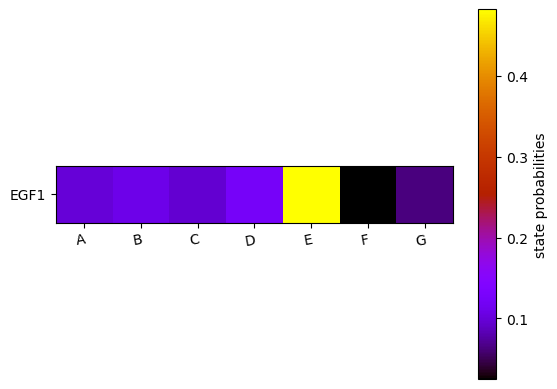

In [30]:
state_probs = np.zeros((n_conds, n_states))
for i in range(n_conds):
    indstm = inds_conditions[i] # Condition Specific Indices of All Trajectories
    indstwm = np.intersect1d(indstm, indstw) # Indices for a given trajectory snippet length
    x0 = Xpcat[indstwm, :] # keep trajectory snippets that are within frame range (72 - 120)
    # Know Indices & calculate (coarse) state probs by Mapping Fine-grain (Microstates) to Coarse-grain (Macrostates)
    indc0 = stateSet[clusters_minima.assign(x0)]  
    statesc, counts = np.unique(indc0, return_counts = True)
    state_probs[i, statesc] = counts/np.sum(counts)

state_order = np.arange(n_states).astype(int)
plt.clf()
plt.imshow(state_probs[:, state_order], cmap=plt.cm.gnuplot)
cbar = plt.colorbar()
cbar.set_label('state probabilities')
# We want to show all ticks...
ax = plt.gca()
ax.set_yticks(np.arange(len(tmSet)))
ax.set_xticks(np.arange(n_states))
ax.set_xticklabels(np.array(state_labels)[state_order])
ax.set_yticklabels(tmSet)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=10, ha="right",rotation_mode="anchor")
plt.pause(.1)

#plt.savefig('stProbs_'+figid+'_nS'+str(nstates)+'pc'+str(nPCs)+'u'+str(neigen_umap)+wellsInfo+'.png')
#np.savetxt('stProbs_'+figid+'_nS'+str(nstates)+'pc'+str(nPCs)+'u'+str(neigen_umap)+wellsInfo+'.dat', state_probs)

<Figure size 640x480 with 0 Axes>

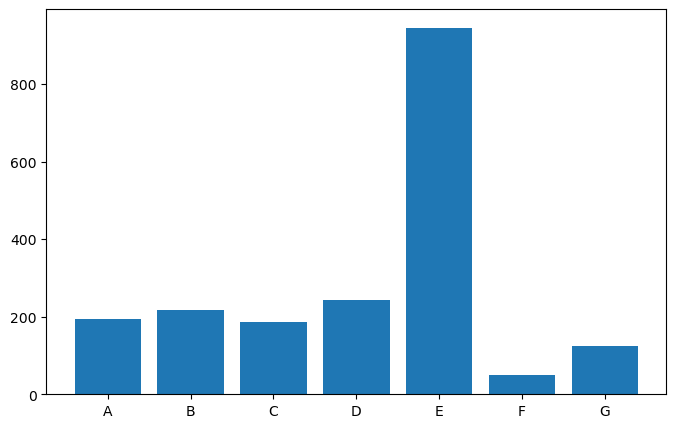

In [31]:
# Map trajectory snippets on the coarse states to generate a histogram 
state_order = np.arange(n_states).astype(int)
macrostates = np.array(state_labels)[state_order]
plt.clf()
plt.figure(figsize = (8, 5))
for i in range(n_conds):
    indstm = inds_conditions[i] # Condition Specific Indices of All Trajectories
    indstwm = np.intersect1d(indstm, indstw) # Indices for a given trajectory snippet length
    x0 = Xpcat[indstwm, :] # keep trajectory snippets that are within frame range (72 - 120)
    # Know Indices & calculate (coarse) state probs by Mapping Fine-grain (Microstates) to Coarse-grain (Macrostates)
    indc0 = stateSet[clusters_minima.assign(x0)]
    statesc, counts = np.unique(indc0, return_counts = True)
    plt.bar(macrostates, counts)

plt.show()

In [51]:
print(indstwm[:100])

[ 209  210  211  212  213  214  215  216  217  218  219  220  221  222
  223  494  495  496  497  498  499  500  501  502  503  504  505  506
  507  508  509  591  592  593  594  595  596  597  598  599  600  601
  602  603  604  605  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  743  744  745  746  747  748  749  750  751  752
  753  754  755  756  757  758  759  760  761  762  763  764  765  766
  767  768  769  770  771  772  773  774  775 1035 1036 1037 1038 1039
 1040 1041]


In [31]:
wells_flg = 0 # Flag to import data of certain wells combinations
if(wells_flg == 0):
  wellsInfo = 'Awells'
  conditions = ['A1','A2','A3','A4','A5','C1','C2','C3'] # LIGANDS (CONDITIONS)
  tmSet = ['OSM1','EGF1','EGF+TGFB1','TGFB1','PBS1','OSM+EGF+TGFB','OSM+EGF','OSM+TGFB']
elif(wells_flg == 1):
  wellsInfo = 'Bwells'
  conditions = ['B1','B2','B3','B4','B5','C1','C2','C3'] # LIGANDS (CONDITIONS)
  tmSet = ['OSM2','EGF2','EGF+TGFB2','TGFB2','PBS2','OSM+EGF+TGFB','OSM+EGF','OSM+TGFB']
else:
  wellsInfo = 'AllWells'
  conditions = ['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','C1','C2','C3'] # LIGANDS (CONDITIONS)
  tmSet = ['OSM1','EGF1','EGF+TGFB1','TGFB1','PBS1','OSM2','EGF2','EGF+TGFB2','TGFB2',
           'PBS2','OSM+EGF+TGFB','OSM+EGF','OSM+TGFB']

In [32]:
def get_cdist2d(prob1):
    nx = prob1.shape[0]; ny = prob1.shape[1]
    prob1 = prob1/np.sum(prob1)
    prob1 = prob1.flatten()
    indprob1 = np.argsort(prob1)
    probc1 = np.zeros_like(prob1)
    probc1[indprob1] = np.cumsum(prob1[indprob1])
    probc1 = 1. - probc1
    probc1 = probc1.reshape((nx, ny))
    return probc1